Processing test dataset...


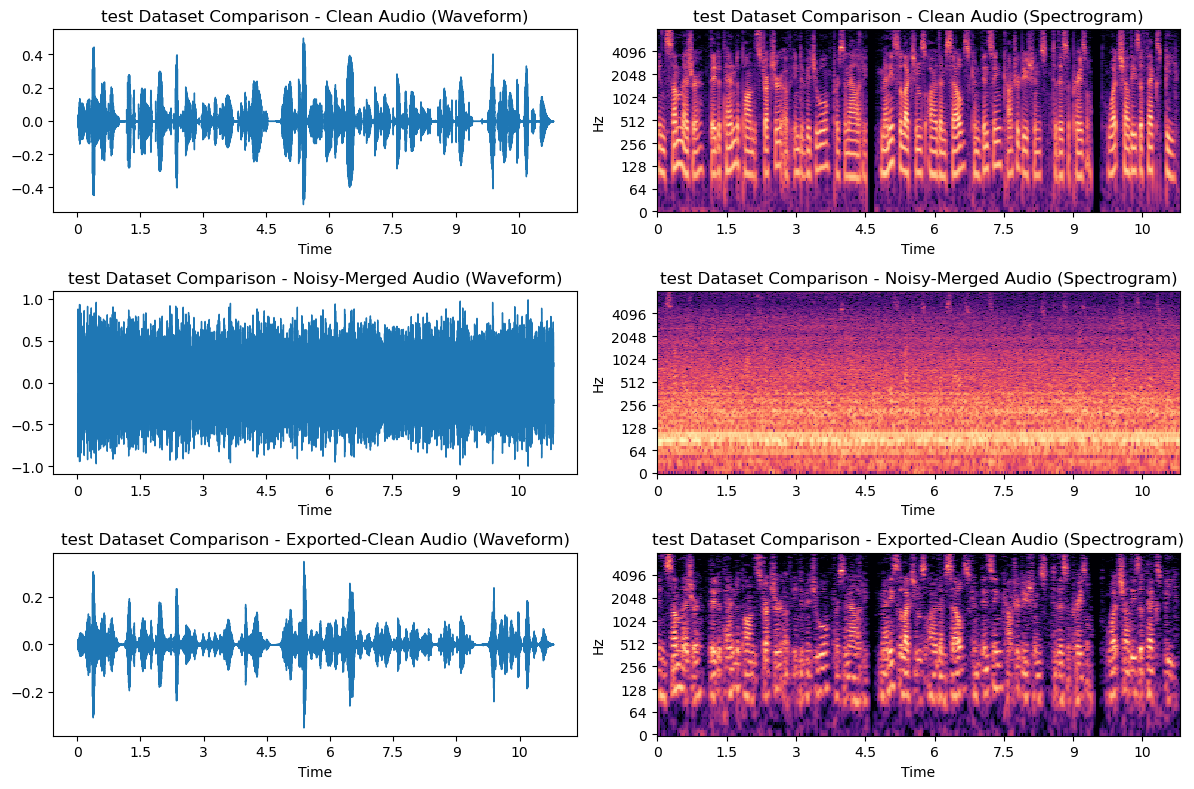

Processing train dataset...


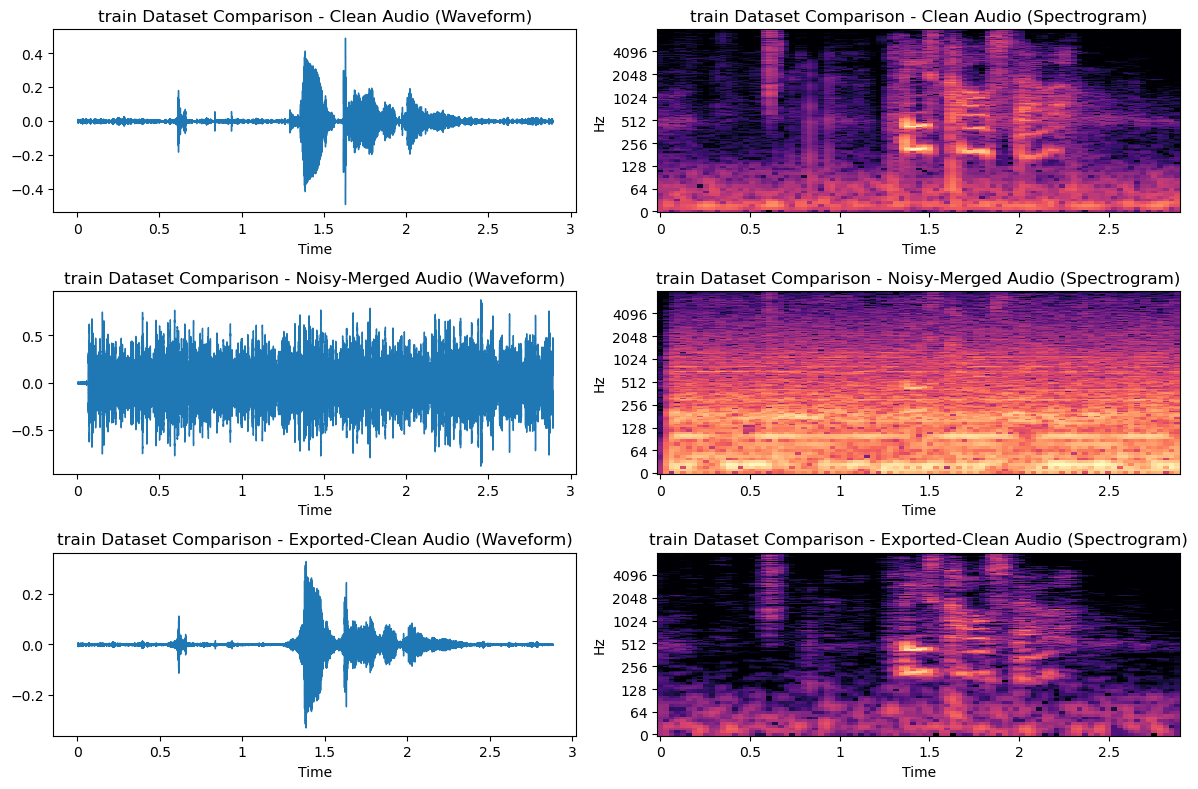

In [1]:
import os
import librosa
import librosa.display
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt

# Define paths
base_path = r"F:\Level 3 Term 2\DSP Project\Data\MS-SNSD-master\MS-SNSD-master"
datasets = {
    "test": {
        "clean_path": os.path.join(base_path, "clean_test"),
        "merged_path": os.path.join(base_path, "noisy_clean_test"),
        "noise_path": os.path.join(base_path, "noise_test"),
        "output_path": os.path.join(base_path, "export_clean_test")
    },
    "train": {
        "clean_path": os.path.join(base_path, "clean_train"),
        "merged_path": os.path.join(base_path, "noisy_clean_train"),
        "noise_path": os.path.join(base_path, "noise_train"),
        "output_path": os.path.join(base_path, "export_clean_train")
    }
}

# Ensure output directories exist
for dataset in datasets.values():
    os.makedirs(dataset["output_path"], exist_ok=True)

# Function to plot waveforms and spectrograms
def plot_comparison(clean_audio, merged_audio, export_audio, sr, title):
    plt.figure(figsize=(12, 8))

    # Plot waveforms
    plt.subplot(3, 2, 1)
    librosa.display.waveshow(clean_audio, sr=sr)
    plt.title(f"{title} - Clean Audio (Waveform)")

    plt.subplot(3, 2, 3)
    librosa.display.waveshow(merged_audio, sr=sr)
    plt.title(f"{title} - Noisy-Merged Audio (Waveform)")

    plt.subplot(3, 2, 5)
    librosa.display.waveshow(export_audio, sr=sr)
    plt.title(f"{title} - Exported-Clean Audio (Waveform)")

    # Plot spectrograms
    plt.subplot(3, 2, 2)
    librosa.display.specshow(librosa.amplitude_to_db(np.abs(librosa.stft(clean_audio)), ref=np.max),
                             sr=sr, x_axis='time', y_axis='log')
    plt.title(f"{title} - Clean Audio (Spectrogram)")

    plt.subplot(3, 2, 4)
    librosa.display.specshow(librosa.amplitude_to_db(np.abs(librosa.stft(merged_audio)), ref=np.max),
                             sr=sr, x_axis='time', y_axis='log')
    plt.title(f"{title} - Noisy-Merged Audio (Spectrogram)")

    plt.subplot(3, 2, 6)
    librosa.display.specshow(librosa.amplitude_to_db(np.abs(librosa.stft(export_audio)), ref=np.max),
                             sr=sr, x_axis='time', y_axis='log')
    plt.title(f"{title} - Exported-Clean Audio (Spectrogram)")

    plt.tight_layout()
    plt.show()

# Function to process, clean audio, and plot
def spectral_subtraction_with_plots(clean_path, merged_path, noise_path, output_path, dataset_name):
    # List files
    clean_files = sorted([os.path.join(clean_path, f) for f in os.listdir(clean_path) if f.endswith('.wav')])
    merged_files = sorted([os.path.join(merged_path, f) for f in os.listdir(merged_path) if f.endswith('.wav')])
    noise_files = sorted([os.path.join(noise_path, f) for f in os.listdir(noise_path) if f.endswith('.wav')])

    # Process first file for visualization
    clean_audio, sr = librosa.load(clean_files[0], sr=None)
    merged_audio, _ = librosa.load(merged_files[0], sr=None)
    noise_audio, _ = librosa.load(noise_files[0], sr=None)

    # Match noise length to merged audio
    if len(noise_audio) > len(merged_audio):
        noise_audio = noise_audio[:len(merged_audio)]
    else:
        noise_audio = np.pad(noise_audio, (0, len(merged_audio) - len(noise_audio)))

    # Spectral subtraction
    noisy_stft = librosa.stft(merged_audio)
    noise_stft = librosa.stft(noise_audio)

    noisy_mag, noisy_phase = librosa.magphase(noisy_stft)
    noise_mag, _ = librosa.magphase(noise_stft)

    # Shape adjustment
    min_frames = min(noisy_mag.shape[1], noise_mag.shape[1])
    noisy_mag = noisy_mag[:, :min_frames]
    noise_mag = noise_mag[:, :min_frames]

    clean_mag = np.maximum(noisy_mag - noise_mag, 0)
    clean_stft = clean_mag * noisy_phase[:, :min_frames]

    # Reconstruct audio
    export_audio = librosa.istft(clean_stft)

    # Save the first processed file
    output_file = os.path.join(output_path, "clean_1.wav")
    sf.write(output_file, export_audio, sr)

    # Plot the comparisons
    plot_comparison(clean_audio, merged_audio, export_audio, sr, f"{dataset_name} Dataset Comparison")

# Process and plot for both datasets
for dataset, paths in datasets.items():
    print(f"Processing {dataset} dataset...")
    spectral_subtraction_with_plots(paths["clean_path"], paths["merged_path"],
                                    paths["noise_path"], paths["output_path"], dataset)
